In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.optimizers import Adam

In [2]:
data = pd.read_csv('exchange_rates.csv')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,exchange_rate
0,2020-01-01,1.0334
1,2020-01-02,1.0292
2,2020-01-03,1.0283
3,2020-01-04,1.0285
4,2020-01-05,1.0296


In [3]:
min_max_scaler = MinMaxScaler()
data['normalized_rate'] = min_max_scaler.fit_transform(data[['exchange_rate']])
data.head()

,date,exchange_rate,normalized_rate
0,2020-01-01,1.0334,0.259755
1,2020-01-02,1.0292,0.236343
2,2020-01-03,1.0283,0.231327
3,2020-01-04,1.0285,0.232441
4,2020-01-05,1.0296,0.238573


In [4]:
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)


look_back = 7
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size], data[train_size:len(data)]
X_train, y_train = create_dataset(train_data['normalized_rate'].values, look_back)
X_test, y_test = create_dataset(test_data['normalized_rate'].values, look_back)

In [5]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),
                               verbose=1,
                               callbacks=[early_stopping,
                                          model_checkpoint])

Epoch 1/100
 1/35 [..............................] - ETA: 4s - loss: 0.1423

2023-12-03 14:26:50.102047: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


35/35 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0163
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 3/100
35/35 [==============================] - 0s 975us/step - loss: 0.0025 - val_loss: 0.0028
Epoch 4/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 5/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/100
35/35 

In [6]:
def plot_history(training_history):
    plt.figure(figsize=(12, 6))
    plt.plot(training_history.history['loss'], label='Train Loss')
    plt.plot(training_history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss during Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

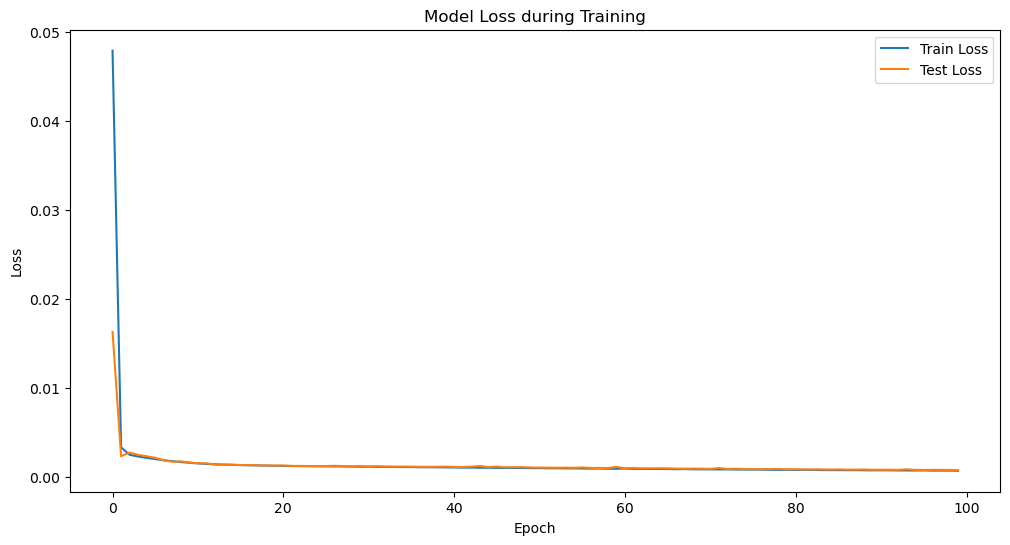

In [7]:
plot_history(history)

In [8]:
best_model = load_model('best_model.h5')
val_loss = best_model.evaluate(X_test, y_test)
print(f'Validation loss: {val_loss:.5f}')

9/9 [==============================] - 0s 556us/step - loss: 7.9413e-04
Validation loss: 0.00079


In [9]:
def plot_predictions(model, X_data, Y_data):
    plt.figure(figsize=(12, 6))
    y_pred_scaled = model.predict(X_data)
    y_pred = min_max_scaler.inverse_transform(y_pred_scaled)
    actual_rate = min_max_scaler.inverse_transform(Y_data.reshape(-1, 1))
    plt.plot(actual_rate, label='Actual Rate')
    plt.plot(y_pred, label='Predicted Rate')
    plt.legend()
    plt.show()

9/9 [==============================] - 0s 509us/step


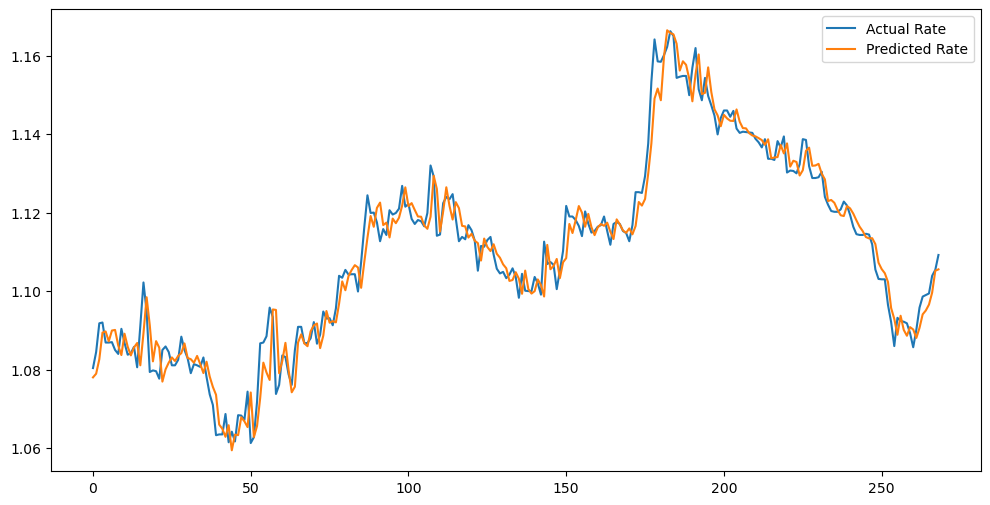

In [10]:
plot_predictions(best_model, X_test, y_test)